In [1]:
import pandas as pd
import numpy as np
import requests
import xmltodict
import urllib.request
import pprint
import json
import csv
np.set_printoptions(suppress=True) 
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier
from eli5.sklearn import PermutationImportance
from sklearn.metrics import r2_score

C:\Users\chosungsu\anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
data = pd.read_csv('data_file_csv_final.csv', encoding='utf-8')

In [3]:
x=np.array(data.loc[: ,['end_destination', 'startplus',
                        'receipt-ride','hour',
                         'startpos1', 'startpos2']])
y=data['endplus']
#  data train,test로 나누기
x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size=0.1, random_state=42, shuffle=False)

In [4]:
base_model = DecisionTreeRegressor(random_state=10)
ada_model = AdaBoostRegressor(
        base_estimator=base_model,
        n_estimators=1000,
        learning_rate=0.1).fit(x_train,y_train)
yte_pred=ada_model.predict(x_test)
ada_r2 = r2_score(y_test, yte_pred)
# AdaBoost 결과 MAE 확인
print('MAE: ', mean_absolute_error(y_test, yte_pred))
print("R2: %.2f" % ada_r2)

MAE:  18.616815476190474
R2: 0.44


In [5]:
rf_clf = RandomForestClassifier()
knn_data = KNeighborsClassifier(n_neighbors=5)
#  개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_data = VotingClassifier(estimators=[("RF", rf_clf), 
                                       ("KNN", knn_data)], voting="soft")
vo_final = vo_data.fit(x_train, y_train)
yte_pred = vo_data.predict(x_test)
vo_r2 = r2_score(y_test, yte_pred)
# VotingClassifier 결과 MAE 확인
print('MAE: ', mean_absolute_error(y_test, yte_pred))
print("R2: %.2f" % vo_r2)

MAE:  16.052884615384617
R2: 0.49


In [6]:
tic = time()
pipe = make_pipeline(QuantileTransformer(),
                     vo_data,
                     ada_model,
                    )
pipe.fit(x_train,y_train)
yte_pred = pipe.predict(x_test)
pipe_r2 = r2_score(y_test, yte_pred)
print("done in {:.3f}s".format(time()-tic))
# Pipeline 결과 MAE 확인
print('MAE: ', mean_absolute_error(y_test, yte_pred))
print("R2: %.2f" % pipe_r2)

done in 1.320s
MAE:  17.882642730040306
R2: 0.44


In [7]:
#x_names : x변수를 리스트화
x_names = ['end_destination', 'startplus',
                        'receipt-ride','hour',
                         'startpos1', 'startpos2']
# permuter 생성
permuter = PermutationImportance(
    pipe,
    scoring='neg_mean_absolute_error',
    n_iter=3,
    random_state=1)
# permutation importance 계산
permuter.fit(x_test, y_test)
# 결과 확인
feature_names = x_names
pd.Series(permuter.feature_importances_, 
          feature_names).sort_values(ascending=False)

startplus          14.556270
startpos2          13.493574
end_destination    13.039375
receipt-ride        7.423259
startpos1           6.880773
hour                0.072245
dtype: float64

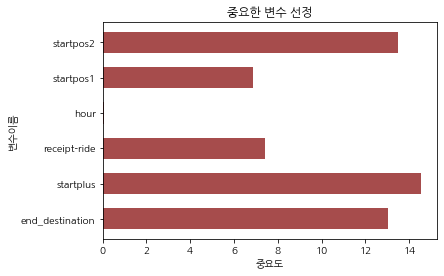

In [8]:
#위 결과를 바탕으로 그린 변수 중요도 파악용 바그래프(참고하세요)
plt.rc('font', family = 'NanumGothic')
plt.barh(feature_names, permuter.feature_importances_, 
        color='maroon', height = 0.6, align='center', alpha = 0.7)
plt.title('중요한 변수 선정')
plt.ylabel('변수이름')
plt.xlabel('중요도')
plt.show()